In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('AAPL.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
#calculate the rolling volatility
rolling_window = 5
df['RollingVol'] = df['LogReturn'].rolling(window=rolling_window).std() * np.sqrt(252)


df

,Open,High,Low,Close,Adj Close,Volume,LogReturn,RollingVol
Date,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800,-0.053581,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087116,105728000,-0.076231,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600,0.024450,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600,0.028580,NaN
...,...,...,...,...,...,...,...,...
2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600,0.005296,0.372553
2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54288300,-0.008335,0.370382
2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007,57388400,-0.006695,0.339006


In [ ]:
# Preprocessing the data

# Dropping NaN values for 'RollingVol' if present
df = df.dropna(subset=['RollingVol'])

# Normalize the 'RollingVol' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['RollingVol'].values.reshape(-1,1))

# Calculate the split point
mid_point = int(len(df) * 0.9)

# Split the data
train_data = scaled_data[:mid_point]
test_data = scaled_data[mid_point:]

# Function to create sequences
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [16]:
trainX, trainY = create_dataset(train_data)
testX, testY = create_dataset(test_data)
# Defining the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the LSTM model on the first half of the data
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Predicting the second half of the data
testPredict = model.predict(testX)

# Inverting predictions to the original scale
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

# Since we do not have actual future values of the RollingVol column,
# we cannot calculate the RMSE for our predictions on the test set.
# RMSE can only be calculated if we have the true future values available.
# However, here is how you would calculate it if you had the true values:
testScore = np.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

Epoch 1/100
9816/9816 - 6s - 589us/step - loss: 7.2124e-04
Epoch 2/100
9816/9816 - 5s - 532us/step - loss: 6.8277e-04
Epoch 3/100
9816/9816 - 5s - 514us/step - loss: 6.6827e-04
Epoch 4/100
9816/9816 - 5s - 515us/step - loss: 6.6902e-04
Epoch 5/100
9816/9816 - 5s - 514us/step - loss: 6.7680e-04
Epoch 6/100
9816/9816 - 5s - 515us/step - loss: 6.5290e-04
Epoch 7/100
9816/9816 - 5s - 510us/step - loss: 6.6224e-04
Epoch 8/100
9816/9816 - 5s - 512us/step - loss: 6.6274e-04
Epoch 9/100
9816/9816 - 5s - 518us/step - loss: 6.6193e-04
Epoch 10/100
9816/9816 - 5s - 514us/step - loss: 6.4806e-04
Epoch 11/100
9816/9816 - 6s - 602us/step - loss: 6.5702e-04
Epoch 12/100
9816/9816 - 5s - 536us/step - loss: 6.5968e-04
Epoch 13/100
9816/9816 - 5s - 548us/step - loss: 6.5855e-04
Epoch 14/100
9816/9816 - 5s - 518us/step - loss: 6.5529e-04
Epoch 15/100
9816/9816 - 5s - 541us/step - loss: 6.7086e-04
Epoch 16/100
9816/9816 - 5s - 512us/step - loss: 6.4903e-04
Epoch 17/100
9816/9816 - 5s - 515us/step - loss: 

Timestamp('2002-07-29 00:00:00')

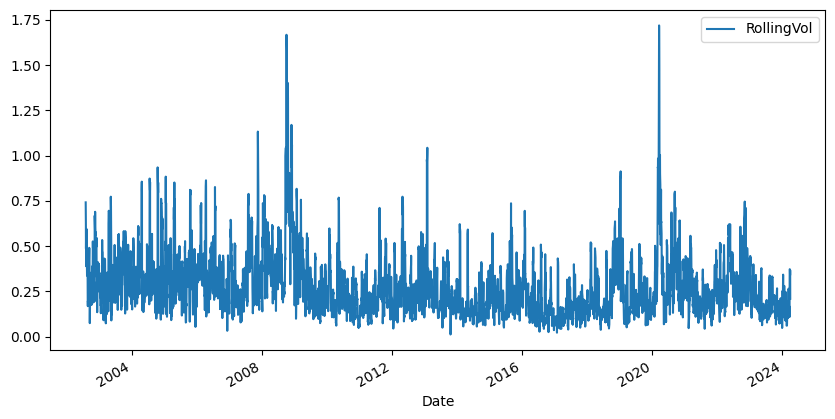

In [ ]:
df[df.index >= df.index[mid_point]].plot(y='RollingVol', figsize=(10,5))
df.index[mid_point]

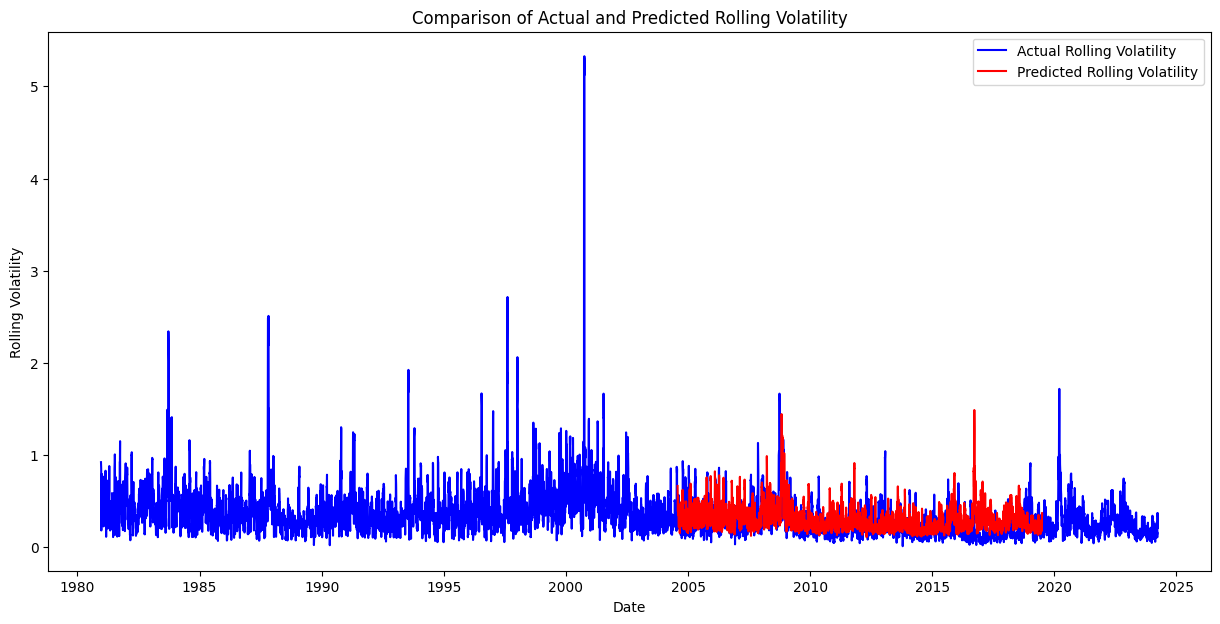

In [13]:

# Assuming you have the following arrays from the previous steps:
# testPredict: the predictions from the LSTM model
# testY_orig: the original true values

# Create a time range for the predictions (you might need to adjust this according to your actual data timestamps)
forecast_dates = pd.date_range(start='2004-07-29', periods=len(testPredict), freq='D')
# Plotting
plt.figure(figsize=(15, 7))

# Plot the actual rolling volatility
plt.plot(df.index, df['RollingVol'], label='Actual Rolling Volatility', color='blue')

# Plot the predicted rolling volatility
plt.plot(forecast_dates,testPredict.flatten(), label='Predicted Rolling Volatility', color='red')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility')
plt.legend()

# Display the plot
plt.show()


In [ ]:
# potential problem: too few data. Yahoo finance find max date and train again